In [ ]:
import ehr_utils, eval_utils
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 281)
pd.set_option('display.width', None)

In [ ]:
# 处理原始数据
def process_xlsx_data(file_name: str) -> None:
    """ 处理xlsx数据，去掉id列，去掉缺失值行，one-hot编码
    
    Args:
        file_name (str): 文件名，不带后缀
    """
    data = pd.read_excel(f'data_original/{file_name}.xlsx', keep_default_na=False, na_values=[""])
    print(data.shape)
    # 去掉id列，将列排序
    data = data[sorted(data.columns)]
    print(data.columns)
    del_col = ['id_patientarchive', "id_patient"]
    cols_to_drop = [c for c in del_col if c in data.columns]
    data.drop(columns=cols_to_drop, inplace=True)
    # 去除有缺失值的行
    print(data.columns)
    missing = data.isna().sum()
    print(missing)
    data.dropna(inplace=True)
    missing = data.isna().sum()
    print(missing)
    print(f'还剩{data.shape[0]}样本')
    os.makedirs('data_processed', exist_ok=True)
    output_path = f'data_processed/{file_name}_cleaned.csv'
    particular_col = ['Alcohol', 'BPH', 'Diabete', 'Hypertension', 'Smoke', 'Stone_history', 'marriage_simplified', 'nation', 'occupation']
    data.to_csv(output_path, index=False, encoding='utf-8-sig')
    df = pd.get_dummies(data, columns=particular_col, dtype='int8')
    output_path = f'data_processed/{file_name}_cleaned_onehot.csv'
    df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(df.shape)


# 场景
benbu = 'benbu_baseline'
shangjin = 'shangjin_baseline'
tianfu = 'tianfu_baseline'
wuhou = 'wuhou_baseline'

process_xlsx_data(benbu)
process_xlsx_data(shangjin)
process_xlsx_data(tianfu)
process_xlsx_data(wuhou)

In [ ]:
def generate_medical_samples(n_samples: int = 10000, random_state: int = 42) -> pd.DataFrame:
    """
    生成医疗数据样本
    
    参数:
        n_samples: 要生成的样本数量
        random_state: 随机种子
    
    返回:
        包含生成数据的DataFrame
    """
    np.random.seed(random_state)
    
    # 定义分类变量的可能值
    categorical_mappings = {
        'Smoke': ['Smoker', 'Never', 'Unknown',],
        'Alcohol': ['Drinker', 'Never', 'Unknown', ],
        'Gender': [0, 1],
        'stone': [True, False],
        'Hypertension': ['None Hypertension', 'Hypertension', 'Unknown'],
        'Diabete': [ 'Diabete', 'None', 'Unknown'],
        'Stone_history': ['None', 'Former Stone Carrier',  'Unknown'],
        'BPH': ['None', 'BPH', 'Unknown'],
        'nation': ['Han People', 'Minority Ethnic Groups', 'Unknown'],
        'occupation': ['No Manual Laborer', 'Manual Laborer', 'Unknown'],
        'marriage_simplified': ['married', 'unmarried', 'Unknown']
    }
    
    data = {}
    
    # 生成ID
    data['id_patientarchive'] = [f'ARCH{i+1:06d}' for i in range(n_samples)]
    data['id_patient'] = [f'P{i+1001:04d}' for i in range(n_samples)]
    
    # 生成连续型变量
    # 肾功能指标
    data['Cystatin.C'] = np.random.uniform(0.6, 1.5, n_samples).round(2)
    data['Creatinine'] = np.random.uniform(45, 120, n_samples).round(0)
    data['Serum_Uric_acid'] = np.random.uniform(150, 500, n_samples).round(0)
    data['Serum_Urea'] = np.random.uniform(2.5, 8.5, n_samples).round(2)
    
    # 尿液检查指标
    data['Uric_RBC'] = np.random.choice([0, 1, 2, 3, 4, 5], n_samples, p=[0.5, 0.25, 0.15, 0.06, 0.03, 0.01])
    data['Uric_WBC'] = np.random.choice([0, 1, 2, 3, 4], n_samples, p=[0.6, 0.25, 0.1, 0.04, 0.01])
    data['Uric_PH'] = np.random.uniform(4.5, 8.0, n_samples).round(1)
    data['Uric_specific_gravity'] = np.random.uniform(1.005, 1.035, n_samples).round(3)
    data['Uric_conductivity'] = np.random.uniform(8, 25, n_samples).round(0)
    data['Uric_epithelium'] = np.random.choice([0, 1, 2], n_samples, p=[0.7, 0.25, 0.05])
    data['Uric_bacteria'] = np.random.choice([0, 1, 2], n_samples, p=[0.8, 0.15, 0.05])
    
    # 血常规指标
    data['RBC'] = np.random.uniform(3.5, 5.5, n_samples).round(2)
    data['RDW.SD'] = np.random.uniform(35, 55, n_samples).round(0)
    data['RDW.CV'] = np.random.uniform(11.0, 16.0, n_samples).round(2)
    data['HCT'] = np.random.uniform(0.35, 0.50, n_samples).round(2)
    data['MCHC'] = np.random.uniform(320, 360, n_samples).round(0)
    data['MCH'] = np.random.uniform(26, 34, n_samples).round(0)
    data['MCV'] = np.random.uniform(80, 100, n_samples).round(0)
    data['HB'] = np.random.uniform(110, 170, n_samples).round(0)
    data['WBC'] = np.random.uniform(4.0, 10.0, n_samples).round(2)
    
    # 白细胞分类
    data['Neutrophil_count'] = np.random.uniform(2.0, 7.0, n_samples).round(2)
    data['Neutrophil_percentage'] = np.random.uniform(40, 70, n_samples).round(0)
    data['Lymphocytes_count'] = np.random.uniform(1.0, 4.0, n_samples).round(2)
    data['Lymphocytes_percentage'] = np.random.uniform(20, 45, n_samples).round(0)
    data['Basophil_count'] = np.random.uniform(0.01, 0.10, n_samples).round(2)
    data['Basophil_percentage'] = np.random.uniform(0.0, 1.5, n_samples).round(2)
    data['Eosinophil_count'] = np.random.uniform(0.05, 0.50, n_samples).round(2)
    data['Eosinophil_percentage'] = np.random.uniform(0.5, 5.0, n_samples).round(2)
    data['Monocytes_count'] = np.random.uniform(0.20, 0.80, n_samples).round(2)
    data['Monocytes_percentage'] = np.random.uniform(3, 10, n_samples).round(2)
    data['platelets_count'] = np.random.uniform(150, 400, n_samples).round(0)
    
    # 肝功能指标
    data['AST'] = np.random.uniform(10, 40, n_samples).round(0)
    data['ALT'] = np.random.uniform(10, 40, n_samples).round(0)
    data['AST_to_ALT_ratio'] = (data['AST'] / data['ALT']).round(2)
    data['DBIL'] = np.random.uniform(1, 8, n_samples).round(0)
    data['IBIL'] = np.random.uniform(5, 20, n_samples).round(0)
    data['TBIL'] = (data['DBIL'] + data['IBIL']).round(0)
    data['Globulin'] = np.random.uniform(20, 35, n_samples).round(0)
    data['Total_protein'] = np.random.uniform(65, 85, n_samples).round(0)
    data['Albumin'] = (data['Total_protein'] - data['Globulin']).round(0)
    data['ALB_to_GLO_ratio'] = (data['Albumin'] / data['Globulin']).round(2)
    
    # 其他生化指标
    data['CK'] = np.random.uniform(50, 200, n_samples).round(0)
    data['AKP'] = np.random.uniform(40, 150, n_samples).round(0)
    data['GGT'] = np.random.uniform(10, 60, n_samples).round(0)
    data['a_HBDH'] = np.random.uniform(80, 200, n_samples).round(0)
    data['LDH'] = np.random.uniform(120, 250, n_samples).round(0)
    data['Fasting_blood_glucose'] = np.random.uniform(3.9, 6.1, n_samples).round(2)
    
    # 血脂指标
    data['Cholesterol'] = np.random.uniform(3.0, 6.5, n_samples).round(2)
    data['Triglycerides'] = np.random.uniform(0.5, 2.5, n_samples).round(2)
    data['HDL'] = np.random.uniform(0.8, 2.0, n_samples).round(2)
    data['LDL'] = np.random.uniform(1.5, 4.5, n_samples).round(2)
    
    # 体征指标
    data['Systolic_BP'] = np.random.uniform(90, 160, n_samples).round(0)
    data['Diastolic_BP'] = np.random.uniform(60, 100, n_samples).round(0)
    data['Height'] = np.random.uniform(150, 185, n_samples).round(0)
    data['Weight'] = np.random.uniform(45, 95, n_samples).round(0)
    data['BMI'] = (data['Weight'] / (data['Height'] / 100) ** 2).round(2)
    data['Waistline'] = np.random.uniform(60, 110, n_samples).round(0)
    data['Hips'] = np.random.uniform(80, 120, n_samples).round(0)
    data['Waist_to_hip_ratio'] = (data['Waistline'] / data['Hips']).round(2)
    
    # 年龄
    data['Age'] = np.random.randint(18, 80, n_samples)
    
    # 计算衍生指标
    # eGFR计算 (简化的CKD-EPI公式)
    data['eGFR'] = np.clip(
        175 * (data['Creatinine'] / 88.4) ** -1.154 * data['Age'] ** -0.203,
        30, 120
    ).round(0)
    
    # 炎症比率指标
    data['NLR'] = (data['Neutrophil_count'] / data['Lymphocytes_count']).round(2)
    data['BLR'] = (data['Basophil_count'] / data['Lymphocytes_count']).round(2)
    data['ELR'] = (data['Eosinophil_count'] / data['Lymphocytes_count']).round(2)
    data['MLR'] = (data['Monocytes_count'] / data['Lymphocytes_count']).round(2)
    data['PLR'] = (data['platelets_count'] / data['Lymphocytes_count']).round(0)
    
    # 体型指标
    data['BRI'] = (data['Waistline'] / (data['Height'] * 0.01)).round(2)
    data['ABSI'] = (data['Waistline'] / (data['BMI'] ** (2/3) * data['Height'] ** 0.5)).round(2)
    
    # 分类变量
    for col, values in categorical_mappings.items():
        if col == 'stone':
            # 结石发生率约30%
            data[col] = np.random.choice(values, n_samples, p=[0.3, 0.7])
        elif col == 'Gender':
            # 性别均衡
            data[col] = np.random.choice(values, n_samples, p=[0.5, 0.5])
        else:
            # 其他分类变量
            weights = [0.4] + [0.6 / (len(values) - 1)] * (len(values) - 1)
            data[col] = np.random.choice(values, n_samples, p=weights)
    
    # 创建DataFrame
    df = pd.DataFrame(data)
    
    return df


# 生成数据
df = generate_medical_samples(n_samples=10000, random_state=42)

# 保存为Excel
df.to_excel('data_original/benbu_baseline.xlsx', index=False)
# df.to_excel('data_original/shangjin_baseline.xlsx', index=False)
# df.to_excel('data_original/tianfu_baseline.xlsx', index=False)
# df.to_excel('data_original/wuhou_baseline.xlsx', index=False)

print(f"成功生成 {len(df)} 条样本数据")
print(f"\n数据预览:")
print(df.head())
print(f"\n数据形状: {df.shape}")
print(f"\n结石分布:")
print(df['stone'].value_counts())

In [ ]:
# 1. 对fake的数据进一步处理
data = pd.read_csv('data_processed/benbu_baseline_cleaned_onehot.csv')

# 2. 划分特征和原始标签
X = data.drop(columns=['stone'])
y = data['stone']

# 3. 训练一个逻辑回归模型（只用原始数据做个“合理”的映射）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. 用模型预测概率
proba = model.predict_proba(X)[:, 1]

# 5. 加入噪声，控制准确率到80%左右
np.random.seed(42)
noise = np.random.rand(len(proba))
threshold = 0.6  # 可调，越小越准
y_simulated = (proba + noise * threshold > 0.5).astype(int)

# 6. 看看模拟标签的准确率（用原模型预测）
print("原模型预测准确率：", accuracy_score(y_simulated, (proba > 0.5).astype(int)))

# 7. 替换原标签
data['stone'] = y_simulated

# 8. 保存新数据
data.to_csv('data_processed/benbu_baseline_cleaned_onehot_simulated80.csv', index=False)

c:\Users\mclab\.conda\envs\calculus\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


原模型预测准确率： 0.3379


=== 步骤1：获取训练集和测试集 ===
总特征数：96，需要log1p变换的特征数：66
训练集样本数：8000，验证集样本数：2000
总特征数：96，需要log1p变换的特征数：66
训练集样本数：8000，验证集样本数：2000
=== 步骤2：评估模型在模拟数据集上的表现 ===


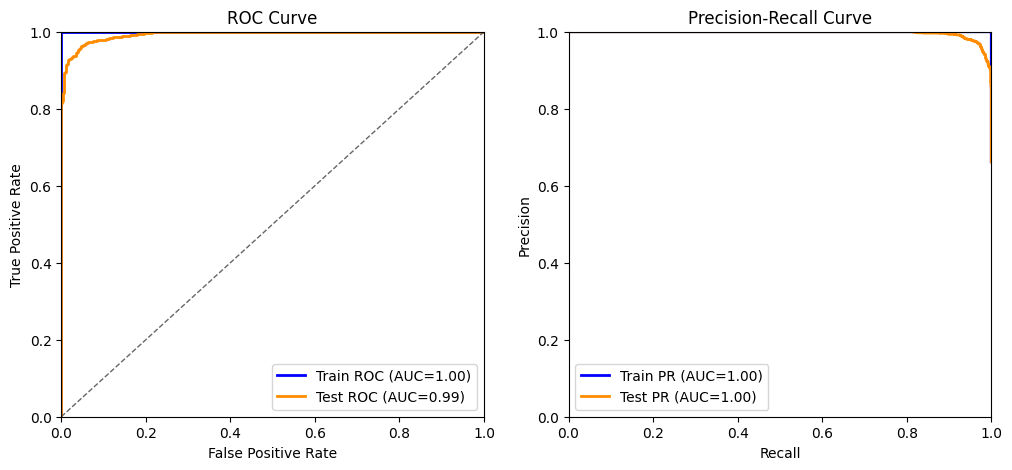

Train AUROC: 1.0000, Test AUROC: 0.9934
Train AUPRC: 1.0000, Test AUPRC: 0.9967
过拟合程度：0.0066


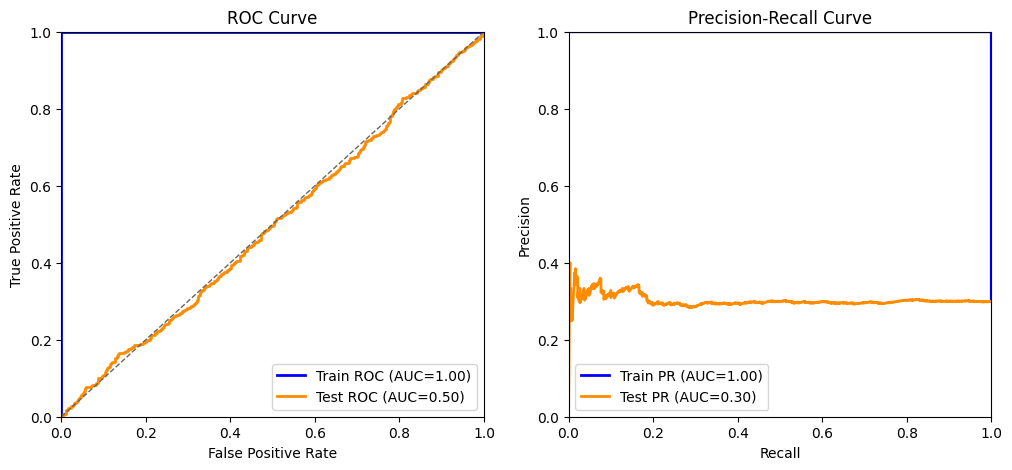

Train AUROC: 1.0000, Test AUROC: 0.4968
Train AUPRC: 1.0000, Test AUPRC: 0.3032
过拟合程度：0.5032


In [ ]:
import xgboost
print("=== 步骤1：获取训练集和测试集 ===")
X_train_simulated, X_test_simulated, y_train_simulated, y_test_simulated = ehr_utils.preprocess_ehr_train_test_data('data_processed/benbu_baseline_cleaned_onehot_simulated80.csv')
X_train, X_test, y_train, y_test = ehr_utils.preprocess_ehr_train_test_data('data_processed/benbu_baseline_cleaned_onehot.csv')
xgb_s=xgboost.XGBClassifier()
xgb=xgboost.XGBClassifier()
xgb_s.fit(X_train_simulated, y_train_simulated)
xgb.fit(X_train, y_train)

y_train_proba_simulated = xgb_s.predict_proba(X_train_simulated)[:, 1]
y_test_proba_simulated = xgb_s.predict_proba(X_test_simulated)[:, 1]
y_train_proba = xgb.predict_proba(X_train)[:, 1]
y_test_proba = xgb.predict_proba(X_test)[:, 1]
print("=== 步骤2：评估模型在模拟数据集上的表现 ===")
eval_utils.plot_roc_pr_curves(y_train_simulated, y_train_proba_simulated, y_test_simulated, y_test_proba_simulated, tag='XGBoost on Simulated Data')
eval_utils.plot_roc_pr_curves(y_train, y_train_proba, y_test, y_test_proba, tag='XGBoost on Original Data')

